# LSTM Networks

Numpy implementation of mnist handwritten digit recognition with LSTM. This code is based on [wiseodd's github.io](http://wiseodd.github.io/techblog/2016/08/12/lstm-backprop/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

## Data preparation

Prepare mnist, weights and delta values to use in training process.

In [2]:
INPUT = 28
HIDDEN = 128
OUTPUT = 10

INPUT += HIDDEN

ALPHA = 0.001
BATCH_SIZE = 64

ITER_NUM = 1000
LOG_ITER = ITER_NUM // 10
PLOT_ITER = ITER_NUM // 200

In [3]:
tf.enable_eager_execution()

In [4]:
mnist = tf.keras.datasets.mnist
(train_x, train_y), _ = mnist.load_data()

In [5]:
dataset = tf.data.Dataset.from_tensor_slices((train_x / 255, train_y))

dataset = dataset.repeat()
dataset = dataset.batch(BATCH_SIZE)

iterator = dataset.make_one_shot_iterator()

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
errors = [] # to plot learning curve of cross entropy

wf = np.random.randn(INPUT, HIDDEN) / np.sqrt(INPUT / 2)
wi = np.random.randn(INPUT, HIDDEN) / np.sqrt(INPUT / 2)
wc = np.random.randn(INPUT, HIDDEN) / np.sqrt(INPUT / 2)
wo = np.random.randn(INPUT, HIDDEN) / np.sqrt(INPUT / 2)
wy = np.random.randn(HIDDEN, OUTPUT) / np.sqrt(HIDDEN / 2)

bf = np.zeros(HIDDEN)
bi = np.zeros(HIDDEN)
bc = np.zeros(HIDDEN)
bo = np.zeros(HIDDEN)
by = np.zeros(OUTPUT)

dwf = np.zeros_like(wf)
dwi = np.zeros_like(wi)
dwc = np.zeros_like(wc)
dwo = np.zeros_like(wo)
dwy = np.zeros_like(wy)

dbf = np.zeros_like(bf)
dbi = np.zeros_like(bi)
dbc = np.zeros_like(bc)
dbo = np.zeros_like(bo)
dby = np.zeros_like(by)

## Function definition

Define activation functions and LSTM cell.

In [7]:
def softmax(arr):
    c = np.clip(arr, -700, 700) # float64 maximum expotentiable value
    e = np.exp(c)
    return e / np.sum(e, axis=1, keepdims=True)

def cross_entropy(out, label):
    entropy = label * np.log(out + 1e-6) # to prevent log value overflow
    return -np.sum(entropy, axis=1, keepdims=True)

def sigmoid(arr):
    c = np.clip(arr, -700, 700)
    return 1 / (1 + np.exp(-c))

def deriv_sigmoid(out):
    return out * (1 - out)

def tanh(arr):
    c = np.clip(arr, -350, 350)
    return 2 / (1 + np.exp(-2 * c)) - 1

def deriv_tanh(out):
    return 1 - np.square(out)

In [8]:
def LSTM_Cell(input_val):
    batch_num = input_val.shape[1]
    
    caches = []
    states = []
    states.append([np.zeros([batch_num, HIDDEN]), np.zeros([batch_num, HIDDEN])])
    
    for x in input_val:
        c_prev, h_prev = states[-1]
    
        x = np.column_stack([x, h_prev])
        hf = sigmoid(np.dot(x, wf) + bf)
        hi = sigmoid(np.dot(x, wi) + bi)
        ho = sigmoid(np.dot(x, wo) + bo)
        hc = tanh(np.dot(x, wc) + bc)
    
        c = hf * c_prev + hi * hc
        h = ho * tanh(c)
    
        states.append([c, h])
        caches.append([x, hf, hi, ho, hc])
        
    return caches, states

In [9]:
def predict(img):
    input_val = np.reshape(img, [28, 1, 28])
    
    caches, states = LSTM_Cell(input_val)
    c, h = states[-1]
    
    pred = softmax(np.dot(h, wy) + by)
    label = np.argmax(pred)
    
    return label

## Training

Train the model of mnist handwritten digit recognition using LSTM.

In [10]:
for i in range(ITER_NUM+1):
    X, Y = iterator.get_next()
    Y = tf.one_hot(Y, 10)
    Xt = np.transpose(X, [1, 0, 2])

    caches, states = LSTM_Cell(Xt)
    c, h = states[-1]
        
    out = np.dot(h, wy) + by
    pred = softmax(out)
    entropy = cross_entropy(pred, Y)
    
    # Backpropagation Through Time
    dout = pred - Y
    dwy = np.dot(h.T, dout)
    dby = np.sum(dout, axis=0)
    
    dc_next = np.zeros_like(c)
    dh_next = np.zeros_like(h)
    
    for t in range(Xt.shape[0]):
        c, h = states[-t-1]
        c_prev, h_prev = states[-t-2]

        x, hf, hi, ho, hc = caches[-t-1]
        
        tc = tanh(c)
        dh = np.dot(dout, wy.T) + dh_next
        
        dc = dh * ho * deriv_tanh(tc)
        dc = dc + dc_next
        
        dho = dh * tc 
        dho = dho * deriv_sigmoid(ho)
        
        dhf = dc * c_prev 
        dhf = dhf * deriv_sigmoid(hf)
        
        dhi = dc * hc 
        dhi = dhi * deriv_sigmoid(hi)
        
        dhc = dc * hi 
        dhc = dhc * deriv_tanh(hc)
        
        dwf += np.dot(x.T, dhf)
        dbf += np.sum(dhf, axis=0)
        dXf = np.dot(dhf, wf.T)
        
        dwi += np.dot(x.T, dhi)
        dbi += np.sum(dhi, axis=0)
        dXi = np.dot(dhi, wi.T)
        
        dwo += np.dot(x.T, dho)
        dbo += np.sum(dho, axis=0)
        dXo = np.dot(dho, wo.T)
        
        dwc += np.dot(x.T, dhc)
        dbc += np.sum(dhc, axis=0)
        dXc = np.dot(dhc, wc.T)

        dX = dXf + dXi + dXo + dXc
        
        dc_next = hf * dc
        dh_next = dX[:, -HIDDEN:]
        
    # Update weights
    wf -= ALPHA * dwf
    wi -= ALPHA * dwi
    wc -= ALPHA * dwc
    wo -= ALPHA * dwo
    wy -= ALPHA * dwy
    
    bf -= ALPHA * dbf
    bi -= ALPHA * dbi
    bc -= ALPHA * dbc
    bo -= ALPHA * dbo
    by -= ALPHA * dby
    
    # Initialize delta values
    dwf *= 0
    dwi *= 0
    dwc *= 0
    dwo *= 0
    dwy *= 0
    
    dbf *= 0
    dbi *= 0
    dbc *= 0
    dbo *= 0
    dby *= 0
    
    # Log training data
    if i % PLOT_ITER == 0:
        errors.append(np.sum(entropy))
    
    if i % LOG_ITER == 0:
        print('iter', i)
        print('entropy', np.sum(entropy))
        print('----------')

iter 0
entropy 147.9892
----------
iter 100
entropy 78.7831
----------
iter 200
entropy 73.92256
----------
iter 300
entropy 20.746746
----------
iter 400
entropy 16.90524
----------
iter 500
entropy 11.90472
----------
iter 600
entropy 5.525634
----------
iter 700
entropy 13.653756
----------
iter 800
entropy 30.601854
----------
iter 900
entropy 15.634008
----------
iter 1000
entropy 12.181253
----------


## Training Result

Plot a learning curve of the cross entropy loss. Also test prediction of new img.

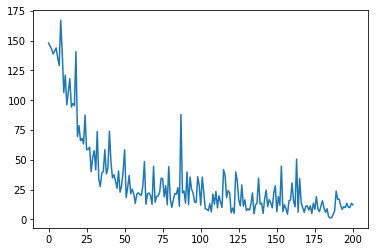

In [11]:
plt.plot(errors)

prediction : 3


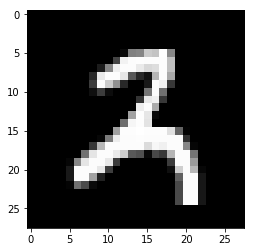

In [12]:
i = np.random.randint(len(train_x))
img = train_x[i]
img = np.reshape(img, [28, 28])

pred = predict(img)
print('prediction :', pred)

plt.imshow(img, cmap='gray')